## Training GenAI for Educational App

This notebook contains the final Agentic Workflow to be used in production.

In [1]:

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import List

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

import os
from supabase import create_client, Client
from dotenv import load_dotenv
from typing import Optional
import graphviz

from datetime import datetime
import io
import re

In [2]:
load_dotenv()

True

### Create `Supabase` Client

In [3]:
url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [6]:
public_url = (
    supabase.storage
    .from_("learning-sources")
    .get_public_url("mindmap_cb1bb773-dcac-44ec-9bca-a1e266bc16b3_20250705_135733.png")
)

In [7]:
public_url

'https://kclenjtsvdayeghmmmkm.supabase.co/storage/v1/object/public/learning-sources/mindmap_cb1bb773-dcac-44ec-9bca-a1e266bc16b3_20250705_135733.png?'

In [430]:
model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
response = model.invoke("Hello World!!")
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--1a16ada3-d8d5-4740-8a3b-acd3c2048f84-0' usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}}


### Learning Mode for Students

A student should get personalized learning experience based on their profile -
1. class level - class 6, 12th, undergrad, postgrad etc.
2. language - hindi, english, marathi etc

We generate following assets
1. Podcast
2. Summary notes
3. Mindmap
4. Quiz - interactable and feedback based, sharable, printable
5. Recommended courses from internet
6. A study action plan

A student can enter 
1. a topic name
2. audio recoding of lecture
3. pdf content

This is multi-step, multi-tool AI Agent so will will use `LangGraph` to build the multi-step `Agent` where each node is assigned some specific task and we will try to stream the response back to the user. I am thinking that each node should do its independent job so we can also run these nodes in parallel because they are kind of not tightly coupled with each other's response.

Check this link for parallelization -> https://langchain-ai.github.io/langgraph/tutorials/workflows/#parallelization

### Initial State for the Agent
Define the State for our Graph workflow

In [431]:

# output structures

class SummaryNoteOutput(BaseModel):
    title: str = Field(description="Title of the note")
    summary: str = Field(description="Summary Note in markdown language")
    

# ------- Quiz --------
class QuestionOptions(BaseModel):
    A: str = Field("Option A for the question")
    B: str = Field("Option B for the question")
    C: str = Field("Option C for the question")
    D: str = Field("Option D for the question")


class Question(BaseModel):
    question: str = Field(
        description="Question")
    options: QuestionOptions
    correctAnswer: str = Field(
        description="Correct answer - one of these options A, B, C or D")
    hint: str = Field(
        description="A small hint to help user think in right direction")
    explaination: str = Field(description="Explaination of the correct answer")


class QuizOutput(BaseModel):
    title: str = Field(description="A suitable title for the quiz.")
    questions: List[Question] = Field(
        description="A list of quiz questions in MCQ format, with each question having 4 options."
    )
    
    
# ---- output for recommend

class Recommendation(BaseModel):
    title: str = Field(description="A title for this recommendation.")
    description: str = Field(description="A brief description.")
    url: str = Field(
        description="source URL of this recommendation if available else NULL.")


class RecommendationList(BaseModel):
    recommendations: List[Recommendation] = Field(
        description="List of recommendations")
    

class PodcastContent(BaseModel):
    topic: str = Field(description="topic of the podcast")
    SSML: str = Field(description="SSML content for the podcast")

In [432]:
class Node(BaseModel):
    id: str
    label: str
    fillcolor: Optional[str] = "white"


class Edge(BaseModel):
    source: str
    target: str
    label: Optional[str] = None


class MindMapStructure(BaseModel):
    # graph_attributes: GraphAttributes
    nodes: List[Node]
    edges: List[Edge]
    central_node: str

In [433]:
# Student profile type definition
from typing import Optional

class StudentProfile(TypedDict):
    gender: str
    class_level: str  # e.g., "class 6", "12th", "undergrad", "postgrad"
    language: str     # e.g., "hindi", "english", "marathi"
    
class UserPrompt(TypedDict):
    topic: str
    file_url: Optional[str]
# Graph state
class State(TypedDict):
    learning_space_id: str
    student_profile: StudentProfile
    user_prompt: UserPrompt
    summary_notes: SummaryNoteOutput
    podcast_script: PodcastContent
    mindmap: str
    quiz: str
    recommendations: str
    study_plan: str
    combined_output: str

Nodes for the Graph

In [434]:
def node_podcast_script(state: State):
    """LLM call to generate podcast script"""

    msg = model.invoke(f"Write an engaging script for a podcast with two speakers - student (male) and teacher (female) on this topic {state['user_prompt']['topic']} of maximum length 20 minutes.")
    return {"podcast_script": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    # msg = model.invoke(f"Write a poem about {state['topic']}")
    return {"poem": "poem"}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    # combined = f"Here's the aggregated {state['topic']}!\n\n"
    # combined += f"podcast_script:\n{state.get('podcast_script')}\n\n"
    # # combined += f"JOKE:\n{state.get('joke')}\n\n"
    # # combined += f"POEM:\n{state.get('poem')}"
    return {"summary_notes": state.get('summary_notes'), "podcast_script": state.get("podcast_script")}

### Agent Node - Notes Summary

In [435]:
## Agent Node - Notes Summary

def node_summary_notes(state: State):
    print("node_summary_notes running....")
    """LLM call to generate summary notes for student"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    # Build human message content dynamically
    user_content = [
        {"type": "text", "text": f"Topic: {state['user_prompt']['topic']}"}]

    # Add file only if it exists
    if state['user_prompt']['file_url'] and state['user_prompt']['file_url'].strip():
        user_content.append({
            "type": "file",
            "url": state['user_prompt']['file_url'],
            "source_type": "url"
        })

    prompt_template = ChatPromptTemplate([
        ("system", """You are an expert academic tutor. Create personalized educational content following these guidelines:
            
            Student Profile:
            - Class Level: {grade_level}
            - Language: {language} 
            - Gender: {gender}
            
            Content Requirements:
            1. Use the audio/image/pdf if provided by the user to genertae concise summary notes
            2. Use bullet points and simple language appropriate for {grade_level}
            3. Include practical examples and analogies
            4. Make it engaging and easy to understand
            5. If language is not English, provide content in {language}
            
            """),
        ("user", user_content)
    ])

    # output structure
    class SummaryNoteOutput(BaseModel):
        title: str = Field(description="Title of the note")
        summary: str = Field(description="Summary Note in markdown language")

    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai").with_structured_output(SummaryNoteOutput)

    chain = prompt_template | model
    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
        }
    )
        
    # update in supabase database
    supabase_response = (
            supabase.table("learning_space")
                .update({"summary_notes": response.model_dump()})
                .eq("id", state["learning_space_id"])
                .execute()
            )

    return {"summary_notes": response}

### Agent Node - Quiz

In [436]:
# Agent Node - Quiz

def node_quiz(state: State):
    print("node_quiz running....")
    """LLM call to generate quiz based on summary content"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    prompt_template = ChatPromptTemplate([
        ("system", """ 
        You are a helpful academic tutor. Use these instructions to create a quiz on the notes provided by the user:
        
        Student Profile:
            - Class Level: {grade_level}
            - Language: {language} 
            - Gender: {gender}
        
        1. Questions should be in MCQ format with 4 options each.
        2. Create 10 quality questions which tests fundamentals and analytical thinking of the user. 
        3. Adapt your language and complexity based on the student's profile provided.
        4. Respond in JSON format which can be used to render a quiz UI.
        5. Include correct answer, hint and explaination with each question.
        """),
        ("user", "Topic Summary {topic_summary}")
    ])

    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai").with_structured_output(QuizOutput)

    chain = prompt_template | model

    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
            "topic_summary": state["summary_notes"]
        }
    )

    # update in supabase database
    supabase_response = (
        supabase.table("learning_space")
        .update({"quiz": response.model_dump()})
        .eq("id", state["learning_space_id"])
        .execute()
    )
    
    if supabase_response.data:
        print("Quiz updated.")
    else:
        print("Some error with supabase update.")

    return {"quiz": response.model_dump()}

### Agent Node - Recommendations

In [437]:
# Agent Node - Quiz

def node_recommendation(state: State):
    print("node_recommendation running....")
    """LLM call to generate quiz based on summary content"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    prompt_template = ChatPromptTemplate([
        ("system", """ 
        You are a helpful academic tutor. Use these instructions to create a recommendation list based on the notes provided by the user:
        
        Student Profile:
            - Class Level: {grade_level}
            - Language: {language} 
            - Gender: {gender}
        
        1. The recommendation should include all the necessary resources to learn the topic.
        2. Create uptp 10 quality recommendations with a mixture of books, online lectures, articles etc. 
        3. Adapt your language and complexity based on the student's profile provided and add proper contextual description and url if available with each source.
        4. Respond in JSON format which can be used to render a UI.
        """),
        ("user", "Topic Summary {topic_summary}")
    ])

    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai").with_structured_output(RecommendationList)

    chain = prompt_template | model

    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
            "topic_summary": state["summary_notes"]
        }
    )
    
    # update in supabase database
    supabase_response = (
        supabase.table("learning_space")
        .update({"recommendations": response.model_dump()})
        .eq("id", state["learning_space_id"])
        .execute()
    )

    if supabase_response.data:
        print("Recommendation updated.")
    else:
        print("Some error with supabase update.")

    return {"recommendations": response.model_dump()}

### Agent Node - Mindmap

In [438]:
def create_balanced_mindmap(mindmap_data):
    """Create a more balanced mindmap layout"""

    dot = graphviz.Digraph(comment='Mindmap')

    # Set graph attributes for better layout
    dot.attr(
        rankdir='TB',  # Top to Bottom
        ranksep='1.5',  # Increase vertical separation
        nodesep='0.8',  # Increase horizontal separation
        splines='ortho',  # Use orthogonal edges
        bgcolor='white'
    )

    # Node styling
    dot.attr('node',
             shape='box',
             style='rounded,filled',
             fontname='Arial',
             fontsize='10',
             width='1.5',
             height='0.8'
             )

    nodes = mindmap_data['nodes']
    edges = mindmap_data['edges']
    central_node = mindmap_data.get('central_node', '')

    # Group nodes by their level (distance from central node)
    node_levels = {}
    for edge in edges:
        if edge['source'] == central_node:
            node_levels[edge['target']] = 1
        elif edge['source'] in node_levels:
            node_levels[edge['target']] = node_levels[edge['source']] + 1

    # Add central node
    dot.node(central_node,
             next(node['label']
                  for node in nodes if node['id'] == central_node),
             fillcolor='#FF6B6B', fontcolor='white', fontsize='12')

    # Add level 1 nodes (main concepts) in subgraphs
    level1_nodes = [node for node in nodes if node['id']
                    in node_levels and node_levels[node['id']] == 1]

    # Create subgraphs for better clustering
    for i, node in enumerate(level1_nodes):
        with dot.subgraph(name=f'cluster_{i}') as cluster:
            cluster.attr(style='invisible')  # Make cluster invisible
            cluster.node(node['id'], node['label'],
                         fillcolor='#4ECDC4', fontcolor='black')

    # Add remaining nodes
    for node in nodes:
        if node['id'] != central_node and node['id'] not in [n['id'] for n in level1_nodes]:
            dot.node(node['id'], node['label'],
                     fillcolor='#96CEB4', fontcolor='black')

    # Add edges
    for edge in edges:
        dot.edge(edge['source'], edge['target'])

    return dot


def upload_mindmap_to_supabase(dot_graph, learning_space_id: str):
    """Upload mindmap image to Supabase Storage"""

    try:
        # Generate image bytes
        image_bytes = dot_graph.pipe(format='png')

        # Create filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"mindmap_{learning_space_id}_{timestamp}.png"

        # Upload to Supabase Storage
        response = supabase.storage.from_('learning-sources').upload(
            path=filename,
            file=image_bytes,
            file_options={
                "content-type": "image/png",
                "upsert": "false"
            }
        )

        print(f"✅ Mindmap uploaded successfully: {filename}")
        return {
            "filename": filename,
            "path": filename
        }

    except Exception as e:
        print(f"❌ Error uploading mindmap: {str(e)}")
        return None

In [439]:
# Agent Node - Notes Summary

def node_mindmap(state: State):
    """LLM call to generate quiz based on summary content"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    prompt_template = ChatPromptTemplate([
        ("system", """ 
        You are a helpful academic tutor.
        Use the below context to create a json response to create a mind map using graph viz in python. The mind map should clearly explain the core concepts and key ideas.
        
        Student Profile:
            - Class Level: {grade_level}
            - Language: {language} 
            - Gender: {gender}
         
        1. Adapt your language and complexity based on the student's profile provided.
        2. Respond in JSON format which can be used to render.
        """),
        ("user", "Topic Summary {topic_summary}")
    ])

    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai").with_structured_output(MindMapStructure)

    chain = prompt_template | model

    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
            "topic_summary": state["summary_notes"]
        }
    )
    
    # create mindmap graph
    json_response = response.model_dump()
    dot = create_balanced_mindmap(json_response)
    
    # upload to supabase storage
    upload_response = upload_mindmap_to_supabase(dot, state['learning_space_id'])

    # # update in supabase database
    supabase_response = (
        supabase.table("learning_space")
        .update({"mindmap": upload_response["path"]})
        .eq("id", state["learning_space_id"])
        .execute()
    )

    # print("Supabase Response", supabase_response)

    return {"mindmap": json_response}

## Agent Audio Overview

In [440]:
# Agent Node - Notes Summary

def node_audio_overview(state: State):
    """LLM call to generate aduio overview based on summary content"""

    # generate the chat prompt

    """Create a personalized prompt based on student profile"""

    prompt_template = ChatPromptTemplate([
    ("system", """
         You are an expert academic female tutor. Your goal is to generate engaging, informative, and personalized educational summaries for students.

        **Strict Guidelines:**

        1.  **Output Format:** The entire response MUST be valid SSML (Speech Synthesis Markup Language).
            * Start with `<speak>`.
            * End with `</speak>`.
            * Use only the SSML tags listed below. Other tags are NOT allowed.

        2.  **Content Length & Duration:**
            * Generate content for a concise audio overview, aiming for a duration of approximately 7-10 minutes.
            * **Crucially, the raw character count of the final SSML string (including all tags, spaces, and content) MUST NOT exceed 3000 characters.** If your content draft exceeds this, you MUST self-edit and shorten it to fit, prioritizing key information.

        **Student Profile:**
        - Class Level: {grade_level}
        - Target Language: {language} (Provide ALL content, including SSML elements like text and prompts, in this language.)
        - Preferred Pronouns: {gender} (e.g., she/her, he/him, they/them – use to personalize direct address, if appropriate for the content style.)

        **Content Requirements:**
        * **Topic Summary:** Generate a detailed and well-structured summary of the user-provided topic.
        * **Academic Appropriateness:** Tailor the depth, complexity, and vocabulary precisely to the specified {grade_level}. Assume foundational knowledge typical for their level, but introduce new concepts clearly.
        * **Engaging Delivery Style:**
            * Write in a conversational, accessible, and enthusiastic tone.
            * Incorporate brief, relatable examples or analogies where helpful.
            * Suggest pauses, changes in speaking rate, or emphasis using SSML tags to enhance listening experience.
        * **Structure:** Follow a logical flow:
            * **Introduction:** Hook the listener, introduce the topic, and greet them.
            * **Main Content:** Break down the topic into digestible segments, explaining core concepts.
            * **Key Takeaways/Recap:** Briefly summarize the main points.
            * **Call to Action/Further Exploration:** Encourage continued learning.

        **Allowed SSML Tags for Amazon Polly Neural Voices (Strictly Enforced):**

        * `<break>`: For adding pauses. Use `time` attribute (e.g., `<break time="500ms"/>` or `<break time="0.5s"/>`).
        * `<lang>`: To specify another language for specific words or phrases.
        * `<mark>`: To place a custom tag in your text.
        * `<p>`: To add a pause between paragraphs.
        * `<phoneme>`: For using phonetic pronunciation.
        * `<prosody>`: For controlling volume, speaking rate, and pitch. **Do NOT use `amazon:max-duration` attribute.** Use attributes like `rate`, `pitch`, `volume`.
        * `<s>`: To add a pause between sentences.
        * `<speak>`: The root element (must be the outermost tag).
        * `<sub>`: To pronounce acronyms and abbreviations (e.g., `<sub alias="Application Programming Interface">API</sub>`).
        * `<w>`: To improve pronunciation by specifying parts of speech (e.g., `<w role="verb">read</w>`).
        * `<amazon:effect name="drc">`: For adding dynamic range compression.

        **Do NOT use any other SSML tags, including (but not limited to):**
        * `<emphasis>`
        * `<prosody amazon:max-duration>`
        * `<amazon:auto-breaths>`
        * `<amazon:effect phonation="soft">`
        * `<amazon:effect vocal-tract-length>`
        * `<amazon:effect name="whispered">`
        * `<amazon:domain name="news">`

        **Example SSML structure and character count consideration:**
        <speak version="1.0" xml:lang="en-US">
          <p>Hello! Welcome to our podcast.</p>
          <s>Today, we explore [Topic].</s>
          <p>This is a brief explanation.</p>
          <s>We'll keep it concise.</s>
          <break time="200ms"/>
          <p><prosody rate="fast">Key takeaway:</prosody> It's very simple.</p>
          <s>Thanks for listening!</s>
        </speak>
        (This example is ~250 chars. Your full content should be around 3000 chars.)
        """
    ),
    ("user", "Generate an audio summary about: {topic_summary}")
])

    # init a new model with structured output
    model = init_chat_model(
        "gemini-2.0-flash", model_provider="google_genai", temperature=0.2).with_structured_output(PodcastContent)

    chain = prompt_template | model

    response = chain.invoke(
        {
            "grade_level": state['student_profile'].get("grade_level", "general"),
            "language": state['student_profile'].get("language", "English"),
            "gender": state['student_profile'].get("gender", ""),
            "topic_summary": state["summary_notes"]
        }
    )
    
    json_response = response.model_dump()
    
    # cleaning SSML

    def clean_podcast_content(content):
        clean_text = re.sub(r"[\n\r\\]", "", content)
        return clean_text

    SSML = clean_podcast_content(json_response['SSML'])
    
    # # # update in supabase database
    supabase_response = (
        supabase.table("learning_space")
        .update({"audio_script": SSML})
        .eq("id", state["learning_space_id"])
        .execute()
    )

    return {"podcast_script": SSML}

## Build Workflow

Build the agentic workflow

In [441]:
parallel_builder = StateGraph(State)

Add all the required nodes

In [442]:

# Add nodes
parallel_builder.add_node("node_summary_notes", node_summary_notes)
parallel_builder.add_node("node_quiz", node_quiz)
parallel_builder.add_node("node_recommendations", node_recommendation)
parallel_builder.add_node("node_mindmap", node_mindmap)

parallel_builder.add_node("node_audio_overview", node_audio_overview)



# parallel_builder.add_node("node_podcast_script", node_podcast_script)
# parallel_builder.add_node("call_llm_3", call_llm_3)
# parallel_builder.add_node("aggregator", aggregator)

Add edges to connect these nodes in meaningful ways.

In [443]:

# parallel_builder.add_edge(START, "node_podcast_script")
parallel_builder.add_edge(START, "node_summary_notes")
parallel_builder.add_edge("node_summary_notes", "node_quiz")
parallel_builder.add_edge("node_summary_notes", "node_recommendations")
parallel_builder.add_edge("node_summary_notes", "node_mindmap")

parallel_builder.add_edge("node_summary_notes", "node_audio_overview")




# parallel_builder.add_edge(START, "call_llm_3")
# parallel_builder.add_edge("node_podcast_script", "aggregator")
# parallel_builder.add_edge("node_summary_notes", "aggregator")
# parallel_builder.add_edge("call_llm_3", "aggregator")

parallel_builder.add_edge("node_quiz", END)
parallel_builder.add_edge("node_recommendations", END)
parallel_builder.add_edge("node_mindmap", END)

parallel_builder.add_edge("node_audio_overview", END)




# parallel_builder.add_edge("aggregator", END)

Compile the model.

In [444]:
parallel_workflow = parallel_builder.compile()

Visualize the graph

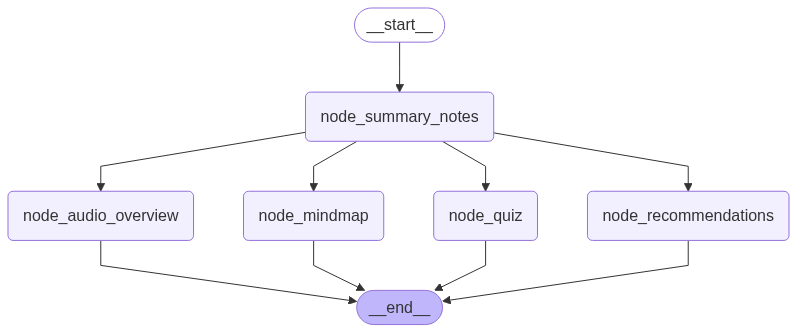

In [445]:
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

### Input State (test) for the Agent

Use this to test out different cases

In [446]:
input_state = {
    "learning_space_id": 'cb1bb773-dcac-44ec-9bca-a1e266bc16b3',
    "student_profile": {
        "gender": "MALE",
        "grade_level": "12th",
        "language": "Hindi"
    },
    "user_prompt": {
        "topic": "Uncertainty in AI",
        "file_url": "https://kclenjtsvdayeghmmmkm.supabase.co/storage/v1/object/public/learning-sources/public/Slides_Module8.pdf",
    }
}

### Invoke the Agentic Workflow

In [447]:
# state = parallel_workflow.invoke({"user_prompt": {"topic": "Photosynthesis"}, "student_profile": {"grade_level": "12th", "gender": "female", "language": "Marathi"}})

state = parallel_workflow.invoke(input_state)

node_summary_notes running....
node_quiz running....node_recommendation running....



I0000 00:00:1751704053.192254  679063 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Recommendation updated.
Quiz updated.
✅ Mindmap uploaded successfully: mindmap_cb1bb773-dcac-44ec-9bca-a1e266bc16b3_20250705_135733.png


### Validate Output

In [448]:
# print(state['podcast_script'])
answer = state['summary_notes'].model_dump()
# print(answer)
Markdown(answer['summary'])

## AI में अनिश्चितता (Uncertainty) - Module 8 का सारांश

यह मॉड्यूल AI सिस्टम्स में अनिश्चितता को मापने और प्रबंधित करने के तरीकों पर केंद्रित है। यहां मुख्य बातें हैं:

*   **अनिश्चितता में काम करना:**
    *   AI एजेंटों को अनिश्चितता से निपटने की आवश्यकता होती है क्योंकि वे हमेशा यह नहीं जानते कि वे किस स्थिति में हैं या कार्यों के बाद कहां पहुंचेंगे।
    *   एजेंट अनिश्चितता को belief state का ट्रैक रखकर संभालते हैं।
    *   उदाहरण: एक ऑटोमेटेड टैक्सी को हवाई अड्डे पर समय पर यात्री को पहुंचाने का लक्ष्य है, लेकिन उसे रास्ते में अनिश्चितताओं का सामना करना पड़ता है।

*   **अनिश्चितता का सारांश:**
    *   अनिश्चित reasoning का एक उदाहरण dental diagnosis है, जिसमें हमेशा अनिश्चितता शामिल होती है।
    *   अनिश्चितता से निपटने के लिए probability theory सबसे अच्छा tool है।
    *   Diagnosis के समय, वास्तविक दुनिया में कोई अनिश्चितता नहीं होती: रोगी को या तो cavity होती है या नहीं।

*   **अनिश्चितता और तर्कसंगत निर्णय:**
    *   सफलता दरों (success rates) की तुलना करना।
    *   Reliability का महत्व।
    *   Trade-offs और inconveniences.
    *   Preferences और outcomes.
    *   Utility theory.
    *   Maximum Expected Utility (MEU) का सिद्धांत।

*   **Basic Probability Notation:**
    *   स्पष्टता और परिशुद्धता (Clarity and Precision)।
    *   उन्नत विश्लेषण (Advanced Analysis) के लिए आधार।
    *   Sample space, probability model, events, unconditional और prior probability, evidence, conditional और posterior probability, product rule.

*   **Probability Assertions में Propositions की भाषा:**
    *   Random variables, domain, probability distribution, probability density function, joint probability distribution, full joint probability distribution.

*   **Probability Axioms:**
    *   Non-negativity axiom, normalization axiom.
    *   Logical consistency, intuitive appeal, mathematical foundation, applicability.
    *   Inclusion-exclusion principle.

*   **Full Joint Distributions का उपयोग करके Inference:**
    *   Probabilistic inference अनिश्चितता में reasoning और decision-making की प्रक्रिया है।
    *   Marginalization, conditional probability, joint inference.
    *   Probabilistic inference की प्रक्रिया में समस्या को define करना, model बनाना, inference करना, और परिणामों का मूल्यांकन करना शामिल है।

*   **Independence:**
    *   Independence का मतलब है कि variables एक दूसरे को प्रभावित नहीं करते हैं।
    *   Marginal independence: variables को अलग-अलग मानना।
    *   Absolute independence: variables एक दूसरे पर condition होने पर भी independent होते हैं।

*   **Bayes' Rule:**
    *   Bayes' Rule probabilistic inference के लिए fundamental है।
    *   P(H|E) = [P(E|H) * P(H)] / P(E)
    *   उदाहरण: spam filtering, medical diagnosis.

यह मॉड्यूल AI में अनिश्चितता की अवधारणा और इससे निपटने के विभिन्न तरीकों की गहरी समझ प्रदान करता है।

In [449]:
state['recommendations']

{'recommendations': [{'title': 'कृत्रिम बुद्धिमत्ता: एक आधुनिक दृष्टिकोण (Artificial Intelligence: A Modern Approach) by Stuart Russell and Peter Norvig',
   'description': 'यह पुस्तक AI में अनिश्चितता के मूल सिद्धांतों को समझने के लिए एक उत्कृष्ट संसाधन है। यह संभाव्यता सिद्धांत, बायेसियन नेटवर्क और निर्णय लेने जैसे विषयों को कवर करता है।',
   'url': 'https://aima.cs.berkeley.edu/'},
  {'title': 'MIT OpenCourseWare: कृत्रिम बुद्धिमत्ता (Artificial Intelligence) - Patrick Winston',
   'description': 'प्रोफेसर पैट्रिक विंस्टन का यह व्याख्यान AI में अनिश्चितता के विभिन्न पहलुओं पर प्रकाश डालता है, जिसमें संभाव्यता तर्क, निर्णय सिद्धांत और बायेसियन नेटवर्क शामिल हैं।',
   'url': 'https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-034-artificial-intelligence-fall-2010/'},
  {'title': 'बायेसियन नेटवर्क (Bayesian Networks) - Scholarpedia',
   'description': 'यह लेख बताता है कि कैसे बायेसियन नेटवर्क का उपयोग AI सिस्टम्स में अनिश्चितता को मॉडल करने के लिए किया जा सकता है

In [450]:
state['podcast_script']

'<speak><p>नमस्ते! आज हम AI में अनिश्चितता के बारे में बात करेंगे।</p><s>यह मॉड्यूल AI सिस्टम्स में अनिश्चितता को मापने और प्रबंधित करने के तरीकों पर केंद्रित है।</s><break time="0.5s"/><p>AI एजेंटों को अनिश्चितता से निपटने की आवश्यकता होती है क्योंकि वे हमेशा यह नहीं जानते कि वे किस स्थिति में हैं या कार्यों के बाद कहां पहुंचेंगे।</p><s>वे belief state का ट्रैक रखकर अनिश्चितता को संभालते हैं।</s><break time="0.3s"/><p>उदाहरण के लिए, एक ऑटोमेटेड टैक्सी को हवाई अड्डे पर समय पर यात्री को पहुंचाने का लक्ष्य है, लेकिन उसे रास्ते में कई अनिश्चितताओं का सामना करना पड़ता है।</p><break time="0.5s"/><p>अनिश्चित reasoning का एक उदाहरण dental diagnosis है, जिसमें हमेशा अनिश्चितता शामिल होती है।</p><s>अनिश्चितता से निपटने के लिए probability theory सबसे अच्छा उपकरण है।</s><break time="0.3s"/><p>Diagnosis के समय, वास्तविक दुनिया में कोई अनिश्चितता नहीं होती: रोगी को या तो cavity होती है या नहीं।</p><break time="0.5s"/><p>सफलता दरों की तुलना करना, reliability का महत्व, trade-offs, preferences और outc